# US Stock Market Prediction using data based on a Window
- This notebook includes W&B Tracking of each run


In [1]:
# Importing necessary packages
import os
import numpy as np
import pandas as pd
import logging
import warnings
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import csv
import lightgbm as lgb

from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')

# Setting up logging with a FileHandler
log_file_path = 'logger_log.txt'
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

file_handler = logging.FileHandler(log_file_path)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))

logger = logging.getLogger(__name__)
logger.addHandler(file_handler)

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
# Reading the dataset
dataset_path = "/kaggle/input/us-stock-market-2020-to-2024/US Stock Market Dataset.csv"

try:
    # Attempt to read the dataset
    df = pd.read_csv(dataset_path)
    logger.info(f"Dataset loaded successfully from {dataset_path}")
except FileNotFoundError:
    logger.error("Error: Dataset file not found. Please provide the correct file path.")
except Exception as e:
    logger.error(f"An error occurred: {e}")
    
# Rename the first column
df = df.rename(columns={df.columns[0]: 'date_index'})
print(df.columns)

df = df[['date_index','Natural_Gas_Price','Natural_Gas_Vol.','Crude_oil_Price', 'Crude_oil_Vol.', 'Copper_Price' , 'Google_Vol.', 'Nvidia_Price',
       'Nvidia_Vol.', 'Berkshire_Price', 'Berkshire_Vol.', 'Netflix_Price',
       'Netflix_Vol.', 'Amazon_Price', 'Amazon_Vol.', 'Meta_Price',
       'Meta_Vol.', 'Gold_Price', 'Gold_Vol.'    ]]

# Remove all commas
df = df.replace(',','', regex=True)

df['prev_index'] = df['date_index'] + 1
df.head(5)

Index(['date_index', 'Date', 'Natural_Gas_Price', 'Natural_Gas_Vol.',
       'Crude_oil_Price', 'Crude_oil_Vol.', 'Copper_Price', 'Copper_Vol.',
       'Bitcoin_Price', 'Bitcoin_Vol.', 'Platinum_Price', 'Platinum_Vol.',
       'Ethereum_Price', 'Ethereum_Vol.', 'S&P_500_Price', 'Nasdaq_100_Price',
       'Nasdaq_100_Vol.', 'Apple_Price', 'Apple_Vol.', 'Tesla_Price',
       'Tesla_Vol.', 'Microsoft_Price', 'Microsoft_Vol.', 'Silver_Price',
       'Silver_Vol.', 'Google_Price', 'Google_Vol.', 'Nvidia_Price',
       'Nvidia_Vol.', 'Berkshire_Price', 'Berkshire_Vol.', 'Netflix_Price',
       'Netflix_Vol.', 'Amazon_Price', 'Amazon_Vol.', 'Meta_Price',
       'Meta_Vol.', 'Gold_Price', 'Gold_Vol.'],
      dtype='object')


,date_index,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Google_Vol.,Nvidia_Price,Nvidia_Vol.,Berkshire_Price,Berkshire_Vol.,Netflix_Price,Netflix_Vol.,Amazon_Price,Amazon_Vol.,Meta_Price,Meta_Vol.,Gold_Price,Gold_Vol.,prev_index
0,0,2.079,NaN,72.28,NaN,3.8215,62500000,661.60,47660000,589498,10580,564.64,4030000,171.81,117220000,474.99,84710000,2053.70,NaN,1
1,1,2.050,161340.0,73.82,577940.0,3.8535,37120000,630.27,36020000,581600,9780,567.51,3150000,159.28,66360000,394.78,25140000,2071.10,260920.0,2
2,2,2.100,142860.0,75.85,344490.0,3.9060,71370000,615.27,45070000,578020,9720,564.11,4830000,155.20,49690000,390.14,20010000,2067.40,238370.0,3
3,3,2.077,139750.0,77.82,347240.0,3.9110,33060000,627.74,39600000,584680,9750,562.85,6120000,159.00,42290000,400.06,18610000,2050.90,214590.0,4
4,4,2.490,3590.0,76.78,331930.0,3.8790,27590000,624.65,33900000,578800,13850,575.79,6880000,161.26,42840000,401.02,17790000,2034.90,1780.0,5


In [3]:
def get_prev_pane(df,y,index_col):
    df['prev_index'] = df[index_col] + y
    column_names = df.columns
    df_tmp = pd.merge(df, df, left_on=index_col, right_on='prev_index', how='inner', suffixes=("_"+str(y),''))
    df_tmp = df_tmp.drop(column_names,axis=1)
    df_tmp = df_tmp.drop(['prev_index'+"_"+str(y),index_col+"_"+str(y)],axis=1)
    return df_tmp

In [4]:
window_back = 70

for i in range (0,window_back,1):
    prev_df = get_prev_pane(df,i,'date_index')
    if i == 0:
        final_df = prev_df
    else:
        final_df = pd.merge(final_df, prev_df, left_index=True, right_index=True)
    
final_df = final_df.iloc[:-window_back]
final_df

,Natural_Gas_Price_0,Natural_Gas_Vol._0,Crude_oil_Price_0,Crude_oil_Vol._0,Copper_Price_0,Google_Vol._0,Nvidia_Price_0,Nvidia_Vol._0,Berkshire_Price_0,Berkshire_Vol._0,...,Berkshire_Price_69,Berkshire_Vol._69,Netflix_Price_69,Netflix_Vol._69,Amazon_Price_69,Amazon_Vol._69,Meta_Price_69,Meta_Vol._69,Gold_Price_69,Gold_Vol._69
0,2.079,NaN,72.28,NaN,3.8215,62500000,661.60,47660000,589498,10580,...,516250,6710,413.73,6440000,128.56,44470000,312.55,18010000,1976.80,1230.0
1,2.050,161340.0,73.82,577940.0,3.8535,37120000,630.27,36020000,581600,9780,...,512500,8920,406.84,7340000,126.56,46690000,314.01,17800000,1978.20,450.0
2,2.100,142860.0,75.85,344490.0,3.9060,71370000,615.27,45070000,578020,9720,...,511000,7790,400.96,12780000,125.17,56410000,308.65,21720000,1994.40,NaN
3,2.077,139750.0,77.82,347240.0,3.9110,33060000,627.74,39600000,584680,9750,...,515550,6990,401.77,27720000,128.40,59610000,312.81,17860000,1980.50,264820.0
4,2.490,3590.0,76.78,331930.0,3.8790,27590000,624.65,33900000,578800,13850,...,518145,7640,346.19,9620000,128.13,42130000,316.97,16720000,1968.30,270050.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869,1.829,165710.0,39.92,487330.0,2.9220,36040000,106.14,30890000,291362,240,...,282800,720,437.49,12660000,119.68,115410000,178.24,16110000,1711.20,186910.0
870,1.854,4060.0,41.27,295860.0,2.9190,22680000,104.65,28450000,294496,250,...,284400,820,422.96,12620000,118.75,158600000,179.24,20970000,1698.80,227070.0
871,1.800,32530.0,41.04,276800.0,2.9175,30910000,102.15,27160000,290940,310,...,282282,780,439.17,16130000,120.41,240760000,176.25,23590000,1731.70,204230.0
872,1.734,37480.0,41.60,377710.0,2.8975,27120000,104.21,29210000,288107,350,...,283750,560,426.75,13560000,115.38,137330000,176.97,17420000,1740.20,186700.0


In [5]:
col_names = final_df.columns[1:].tolist()
print(col_names)

# creating a copy of df
df1 = final_df.fillna(0)

#target column name
label_name = 'Natural_Gas_Price_0'

# defining the features and target
X = df1.drop([label_name],axis=1)
y = df1[[label_name]]

# instantiating the scaler
scaler = RobustScaler()

# scaling the continuous featuree
X[col_names] = scaler.fit_transform(X[col_names])

# Get centering and scaling values for each feature
centering = scaler.center_
iqrs  = scaler.scale_

X.head()

['Natural_Gas_Vol._0', 'Crude_oil_Price_0', 'Crude_oil_Vol._0', 'Copper_Price_0', 'Google_Vol._0', 'Nvidia_Price_0', 'Nvidia_Vol._0', 'Berkshire_Price_0', 'Berkshire_Vol._0', 'Netflix_Price_0', 'Netflix_Vol._0', 'Amazon_Price_0', 'Amazon_Vol._0', 'Meta_Price_0', 'Meta_Vol._0', 'Gold_Price_0', 'Gold_Vol._0', 'Natural_Gas_Price_1', 'Natural_Gas_Vol._1', 'Crude_oil_Price_1', 'Crude_oil_Vol._1', 'Copper_Price_1', 'Google_Vol._1', 'Nvidia_Price_1', 'Nvidia_Vol._1', 'Berkshire_Price_1', 'Berkshire_Vol._1', 'Netflix_Price_1', 'Netflix_Vol._1', 'Amazon_Price_1', 'Amazon_Vol._1', 'Meta_Price_1', 'Meta_Vol._1', 'Gold_Price_1', 'Gold_Vol._1', 'Natural_Gas_Price_2', 'Natural_Gas_Vol._2', 'Crude_oil_Price_2', 'Crude_oil_Vol._2', 'Copper_Price_2', 'Google_Vol._2', 'Nvidia_Price_2', 'Nvidia_Vol._2', 'Berkshire_Price_2', 'Berkshire_Vol._2', 'Netflix_Price_2', 'Netflix_Vol._2', 'Amazon_Price_2', 'Amazon_Vol._2', 'Meta_Price_2', 'Meta_Vol._2', 'Gold_Price_2', 'Gold_Vol._2', 'Natural_Gas_Price_3', 'Natur

,Natural_Gas_Vol._0,Crude_oil_Price_0,Crude_oil_Vol._0,Copper_Price_0,Google_Vol._0,Nvidia_Price_0,Nvidia_Vol._0,Berkshire_Price_0,Berkshire_Vol._0,Netflix_Price_0,...,Berkshire_Price_69,Berkshire_Vol._69,Netflix_Price_69,Netflix_Vol._69,Amazon_Price_69,Amazon_Vol._69,Meta_Price_69,Meta_Vol._69,Gold_Price_69,Gold_Vol._69
0,-1.726612,-0.174643,-2.459505,-0.092822,2.589704,3.162528,0.187892,1.800274,2.263994,0.646261,...,0.867703,1.664884,-0.111436,0.243292,-0.359130,-0.644329,0.448374,-0.292874,0.958000,-2.165190
1,0.595495,-0.092521,1.807309,-0.044720,0.609984,2.948331,-0.334081,1.702967,2.042847,0.661506,...,0.829019,2.452763,-0.148270,0.457961,-0.403993,-0.575774,0.461330,-0.309319,0.967523,-2.174689
2,0.329519,0.015731,0.083795,0.034198,3.281591,2.845779,0.071749,1.658860,2.026261,0.643446,...,0.813545,2.049911,-0.179704,1.755516,-0.435173,-0.275612,0.413764,-0.002349,1.077708,-2.180169
3,0.284758,0.120784,0.104097,0.041714,0.293292,2.931034,-0.173543,1.740914,2.034554,0.636754,...,0.860482,1.764706,-0.175374,5.319022,-0.362719,-0.176793,0.450681,-0.304620,0.983166,1.044723
4,-1.674942,0.065325,-0.008933,-0.006389,-0.133385,2.909908,-0.429148,1.668470,3.167934,0.705486,...,0.887252,1.996435,-0.472502,1.001789,-0.368775,-0.716591,0.487598,-0.393892,0.900187,1.108412


In [6]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [7]:
# Defining a dictionary of regression models
regressors = {
    'AdaBoostRegressor': AdaBoostRegressor(),
    'LinearRegression': LinearRegression(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=0),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=300, max_depth=1, subsample=0.8, max_features=0.2),
    'XGBRegressor': XGBRegressor(objective='reg:squarederror'),
}

AdaBoostRegressor CV Scores: [-0.09482144 -0.06830629 -0.05324147 -0.0620412  -0.0597913 ]
AdaBoostRegressor Mean Squared Error (MSE): 0.06499555133333443
AdaBoostRegressor Root Mean Squared Error (RMSE): 0.2549422509772251
AdaBoostRegressor Mean Absolute Error (MAE): 0.1811498795640711
AdaBoostRegressor R^2 Score: 0.9813423512760838


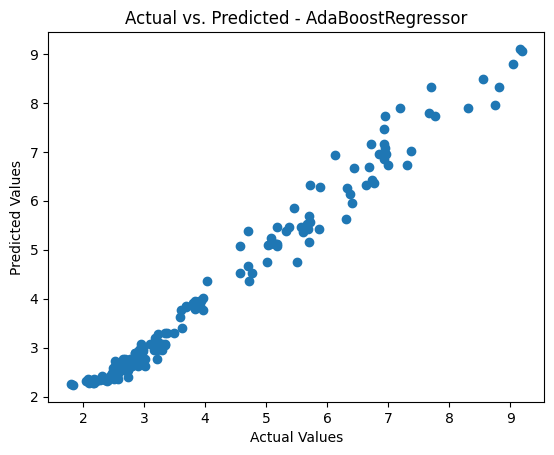

LinearRegression CV Scores: [-0.18314523 -0.19906911 -0.21060061 -0.25228236 -0.25550668]
LinearRegression Mean Squared Error (MSE): 0.1774233131756077
LinearRegression Root Mean Squared Error (RMSE): 0.42121646831006937
LinearRegression Mean Absolute Error (MAE): 0.3395926980147043
LinearRegression R^2 Score: 0.9490687934057711


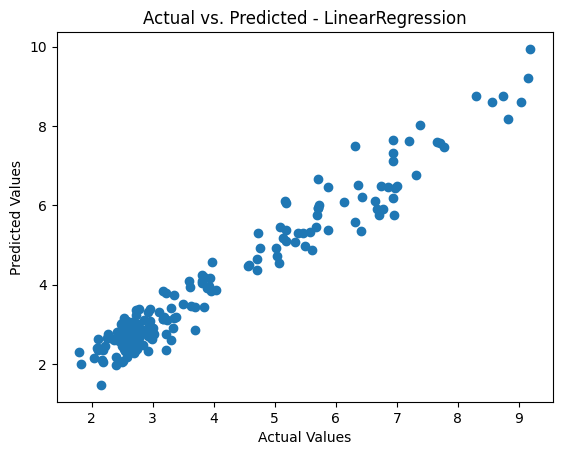

KNeighborsRegressor CV Scores: [-0.58256052 -0.19593822 -0.18588122 -0.20715181 -0.21718354]
KNeighborsRegressor Mean Squared Error (MSE): 0.16512205531428567
KNeighborsRegressor Root Mean Squared Error (RMSE): 0.40635213216406985
KNeighborsRegressor Mean Absolute Error (MAE): 0.23003657142857142
KNeighborsRegressor R^2 Score: 0.9525999973625126


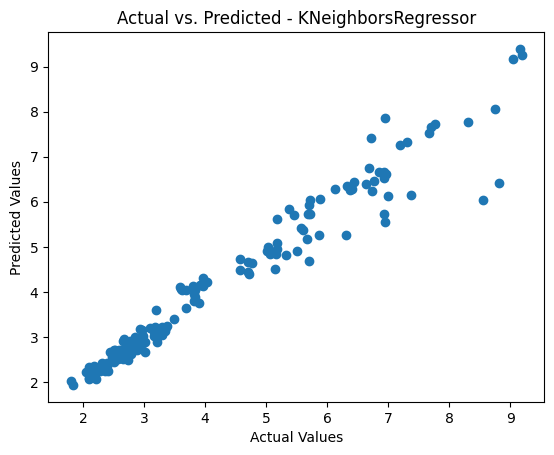

RandomForestRegressor CV Scores: [-0.09234833 -0.05118813 -0.04116717 -0.04861491 -0.04939868]
RandomForestRegressor Mean Squared Error (MSE): 0.056401352162285756
RandomForestRegressor Root Mean Squared Error (RMSE): 0.23748968853886215
RandomForestRegressor Mean Absolute Error (MAE): 0.15912091428571426
RandomForestRegressor R^2 Score: 0.9838094054960633


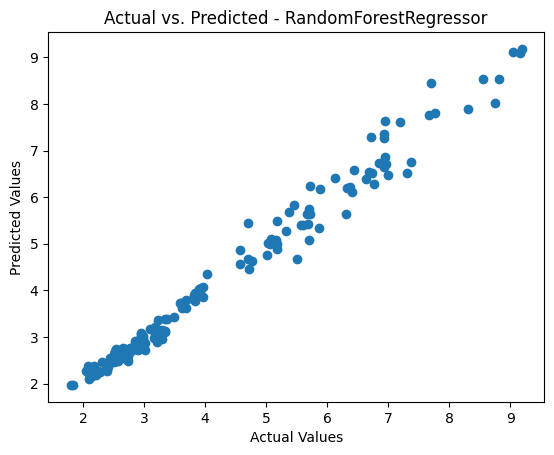

GradientBoostingRegressor CV Scores: [-0.09070796 -0.09143925 -0.06526128 -0.08291381 -0.066714  ]
GradientBoostingRegressor Mean Squared Error (MSE): 0.08874973276077941
GradientBoostingRegressor Root Mean Squared Error (RMSE): 0.29790893367064275
GradientBoostingRegressor Mean Absolute Error (MAE): 0.20740781136593697
GradientBoostingRegressor R^2 Score: 0.9745234665415814


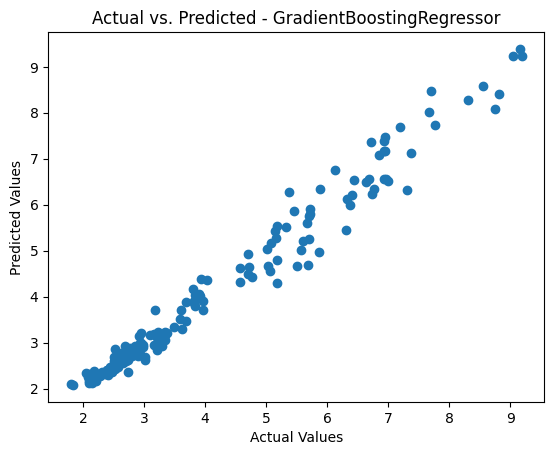

XGBRegressor CV Scores: [-0.07718338 -0.05958665 -0.04481225 -0.05570398 -0.05669034]
XGBRegressor Mean Squared Error (MSE): 0.07352944655851747
XGBRegressor Root Mean Squared Error (RMSE): 0.2711631364299312
XGBRegressor Mean Absolute Error (MAE): 0.1721468696158273
XGBRegressor R^2 Score: 0.9788926079307033


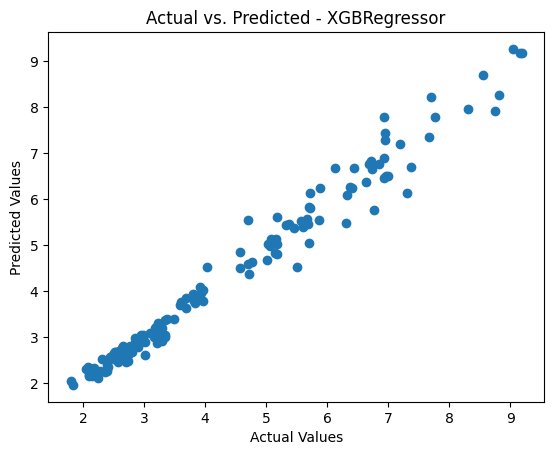

In [8]:
# Improved model evaluation and cross-validation for regression
model_results = []

# Looping through regression models and evaluating their performance
for name, model in regressors.items():
    try:
        logger.info(f"Training and evaluating {name} model.")
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

        # Model training
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Evaluation metrics for regression
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)

        model_results.append({'Model': name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R^2': r2, 'CV Scores': cv_scores})
        
        print("=============================================================================")
        print(name, "CV Scores:", cv_scores)
        print(name, "Mean Squared Error (MSE):", mse)
        print(name, "Root Mean Squared Error (RMSE):", rmse)
        print(name, "Mean Absolute Error (MAE):", mae)
        print(name, "R^2 Score:", r2)
        
        logger.info(f"{name} - CV Scores: {cv_scores}")
        logger.info(f"{name} - MSE: {mse}")
        logger.info(f"{name} - RMSE: {rmse}")
        logger.info(f"{name} - MAE: {mae}")
        logger.info(f"{name} - R^2 Score: {r2}")

        # Plotting the actual vs. predicted values
        plt.scatter(y_test, predictions)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs. Predicted - {name}')
        plt.show()

    except Exception as ex:
        print(ex)
        logger.error(f"An error occurred while processing {name} model: {ex}")


## Model Results Baseline
- MSE is the one that we will use as MSE penalizes larger errors more heavily, which can be important in financial forecasting where large errors may have significant consequences.

In [9]:
df_results = pd.DataFrame(model_results)
df_results

,Model,MSE,RMSE,MAE,R^2,CV Scores
0,AdaBoostRegressor,0.064996,0.254942,0.181150,0.981342,"[-0.0948214434389331, -0.06830628757143337, -0..."
1,LinearRegression,0.177423,0.421216,0.339593,0.949069,"[-0.1831452332788827, -0.19906911479686898, -0..."
2,KNeighborsRegressor,0.165122,0.406352,0.230037,0.952600,"[-0.5825605154285713, -0.19593822285714288, -0..."
3,RandomForestRegressor,0.056401,0.237490,0.159121,0.983809,"[-0.09234832838285768, -0.05118813299142871, -..."
4,GradientBoostingRegressor,0.088750,0.297909,0.207408,0.974523,"[-0.09070796193366296, -0.09143925002177555, -..."
5,XGBRegressor,0.073529,0.271163,0.172147,0.978893,"[-0.07718338078959905, -0.05958664890865776, -..."


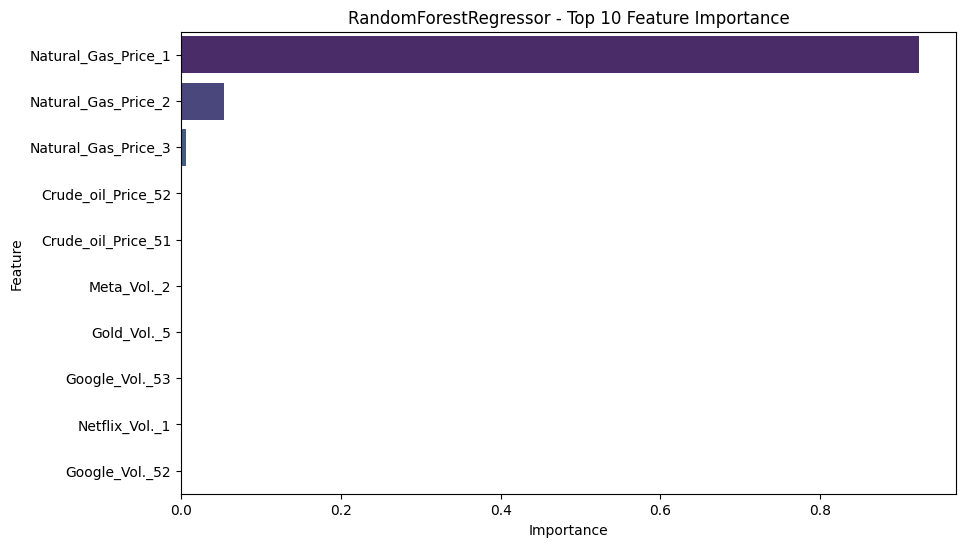

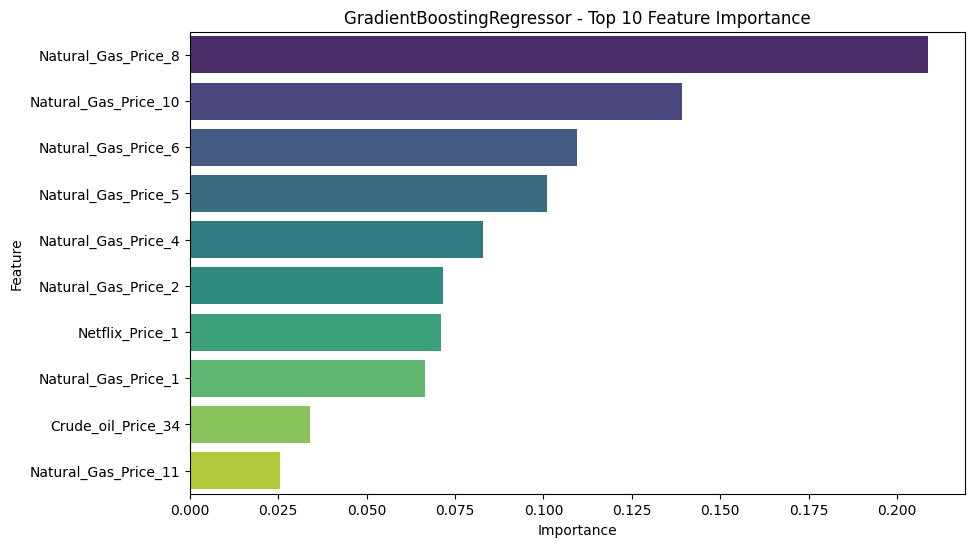

In [10]:
# Feature importance for tree-based models
for name, model in regressors.items():
    if isinstance(model, (RandomForestRegressor, GradientBoostingRegressor)):
        model.fit(X_train, y_train)
        feature_importances = model.feature_importances_
        feature_names = X_train.columns
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
        sorted_df = importance_df.sort_values(by='Importance', ascending=False)
        
        # Display only the top 10 features
        top_10_features = sorted_df.head(10)
        
        # Create seaborn bar plot for the top 10 features
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')
        plt.title(f"{name} - Top 10 Feature Importance")
        plt.show()


## Big Model

In [11]:
# Define parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 1000,
    'max_depth': 5000,
    'num_iterations':5000,
    'is_enable_sparse': 'true',
    'learning_rate': 0.001,
    'max_bin':50000,
    'max_drop': 1,
    'feature_fraction': 0.95,
    'verbose': -1
}

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'num_leaves': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'feature_fraction': [0.8, 0.9, 1.0],
    'device': ['gpu'],
    'verbose': -1
}

callbacks = [lgb.early_stopping(50)]
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

try:
    # Try using GPU
    params['device'] = 'gpu'    
except lgb.basic.LightGBMError as e:
    # GPU training not supported, fall back to CPU
    del params['device']

# Train Model
bst = lgb.train(params, train_data, valid_sets=[test_data], callbacks=callbacks)

# Make predictions on the test set
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

 # Evaluation metrics for regression
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

model_results.append({'Model': name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R^2': r2, 'CV Scores': cv_scores})

print("=============================================================================")
print(name, "CV Scores:", cv_scores)
print(name, "Mean Squared Error (MSE):", mse)
print(name, "Root Mean Squared Error (RMSE):", rmse)
print(name, "Mean Absolute Error (MAE):", mae)
print(name, "R^2 Score:", r2)


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[5000]	valid_0's rmse: 0.250324
Root Mean Squared Error (RMSE): 0.2503239434452444
XGBRegressor CV Scores: [-0.07718338 -0.05958665 -0.04481225 -0.05570398 -0.05669034]
XGBRegressor Mean Squared Error (MSE): 0.07352944655851747
XGBRegressor Root Mean Squared Error (RMSE): 0.2711631364299312
XGBRegressor Mean Absolute Error (MAE): 0.1721468696158273
XGBRegressor R^2 Score: 0.9788926079307033


In [12]:
# Save log messages to a file
# File handling: close the FileHandler
file_handler.close()
logger.removeHandler(file_handler)